# Modeling and Simulation in Python

Chapter 25

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
def plot_theta(results):
    plot(results.theta, color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    


In [3]:
def plot_y(results):
    plot(results.y, color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    


In [4]:
def plot_r(results):
    plot(results.r, color='C2', label='r')

    decorate(xlabel='Time (s)',
             ylabel='Radius (mm)')
    


### Unrolling

We'll start by loading the units we need.

In [5]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

And a few more parameters in the `Params` object.

In [6]:
params = Params(Rmin = 0.02 * m,
                Rmax = 0.055 * m,
                Mcore = 15e-3 * kg,
                Mroll = 215e-3 * kg,
                L = 47 * m,
                tension = 2e-4 * N,
                t_end = 180 * s)

,values
Rmin,0.02 meter
Rmax,0.055 meter
Mcore,0.015 kilogram
Mroll,0.215 kilogram
L,47 meter
tension,0.0002 newton
t_end,180 second


`make_system` computes `rho_h`, which we'll need to compute moment of inertia, and `k`, which we'll use to compute `r`.

In [7]:
def make_system(params):
    """Make a system object.
    
    params: Params with Rmin, Rmax, Mcore, Mroll,
                              L, tension, and t_end
    
    returns: System with init, k, rho_h, Rmin, Rmax,
                         Mcore, Mroll, ts
    """
    unpack(params)
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L)
    
    area = pi * (Rmax**2 - Rmin**2)
    rho_h = Mroll / area
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    
    return System(init=init, k=k, rho_h=rho_h,
                  Rmin=Rmin, Rmax=Rmax,
                  Mcore=Mcore, Mroll=Mroll, 
                  t_end=t_end)

Testing `make_system`

In [8]:
system = make_system(params)

,values
init,theta 0 radian omega 0.0 radi...
k,2.7925531914893616e-05 meter / radian
rho_h,26.07109543981524 kilogram / meter ** 2
Rmin,0.02 meter
Rmax,0.055 meter
Mcore,0.015 kilogram
Mroll,0.215 kilogram
t_end,180 second


In [9]:
system.init

,values
theta,0 radian
omega,0.0 radian / second
y,47 meter


Here's how we compute `I` as a function of `r`:

In [10]:
def moment_of_inertia(r, system):
    """Moment of inertia for a roll of toilet paper.
    
    r: current radius of roll in meters
    system: System object with Mcore, rho, Rmin, Rmax
    
    returns: moment of inertia in kg m**2
    """
    unpack(system)
    Icore = Mcore * Rmin**2   
    Iroll = pi * rho_h / 2 * (r**4 - Rmin**4)
    return Icore + Iroll

When `r` is `Rmin`, `I` is small.

In [11]:
moment_of_inertia(system.Rmin, system)

<Quantity(6e-06, 'kilogram * meter ** 2')>

As `r` increases, so does `I`.

In [12]:
moment_of_inertia(system.Rmax, system)

<Quantity(0.00037418750000000006, 'kilogram * meter ** 2')>

Here's the slope function.

In [13]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, omega, y
    t: time
    system: System object with Rmin, k, Mcore, rho_h, tension
    
    returns: sequence of derivatives
    """
    theta, omega, y = state
    unpack(system)
    
    r = sqrt(2*k*y + Rmin**2)
    I = moment_of_inertia(r, system)
    tau = r * tension
    alpha = tau / I
    dydt = -r * omega
    
    return omega, alpha, dydt      

Testing `slope_func`

In [14]:
slope_func(system.init, 0*s, system)

(<Quantity(0.0, 'radian / second')>,
 <Quantity(0.02939702689159846, 'newton / kilogram / meter / radian ** 0.5')>,
 <Quantity(-0.0, 'meter * radian ** 0.5 / second')>)

Now we can run the simulation.

In [15]:
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,38
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


And look at the results.

In [16]:
results.tail()

,theta,omega,y
0.374180,0.002058,0.011000,46.999887
3.775812,0.209564,0.111009,46.988475
37.792133,21.106431,1.123035,45.845366
160.640735,425.331869,6.027022,26.131970
180.000000,554.465218,7.372803,20.796329


Plotting `theta`

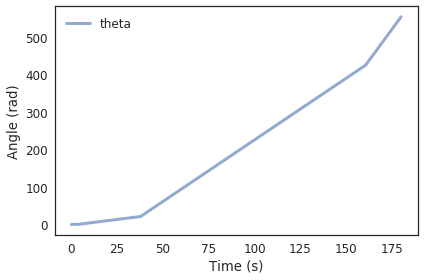

In [17]:
plot_theta(results)

Plotting `omega`

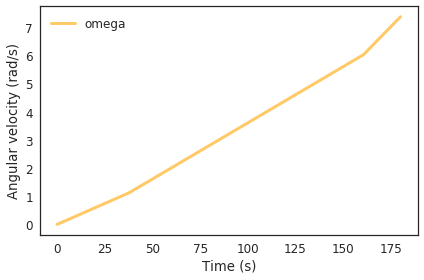

In [18]:
def plot_omega(results):
    plot(results.omega, color='orange', label='omega')

    decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')
    
plot_omega(results)

Plotting `y`

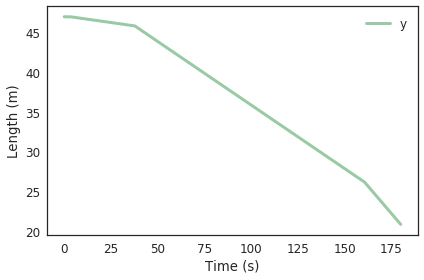

In [19]:
plot_y(results)

Here's the figure from the book.

Saving figure to file figs/chap11-fig02.pdf


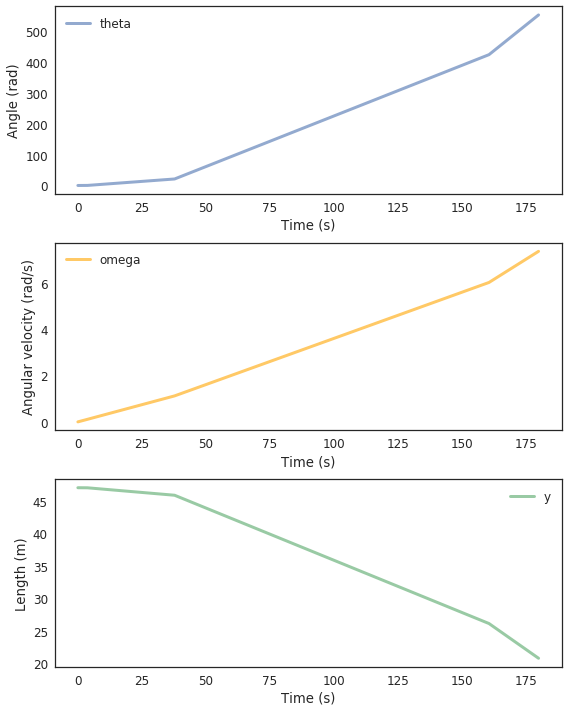

In [20]:
subplot(3, 1, 1)
plot_theta(results)

subplot(3, 1, 2)
plot_omega(results)

subplot(3, 1, 3)
plot_y(results)

savefig('figs/chap11-fig02.pdf')

### Yo-yo

**Exercise:**  Simulate the descent of a yo-yo.  How long does it take to reach the end of the string?

I provide a `Params` object with the system parameters:

* `Rmin` is the radius of the axle.  `Rmax` is the radius of the axle plus rolled string.

* `Rout` is the radius of the yo-yo body.  `mass` is the total mass of the yo-yo, ignoring the string.  

* `L` is the length of the string.

* `g` is the acceleration of gravity.

In [21]:
params = Params(Rmin = 8e-3 * m,
                Rmax = 16e-3 * m,
                Rout = 35e-3 * m,
                mass = 50e-3 * kg,
                L = 1 * m,
                g = 9.8 * m / s**2,
                t_end = 1 * s)

,values
Rmin,0.008 meter
Rmax,0.016 meter
Rout,0.035 meter
mass,0.05 kilogram
L,1 meter
g,9.8 meter / second ** 2
t_end,1 second


Here's a `make_system` function that computes `I` and `k` based on the system parameters.

I estimated `I` by modeling the yo-yo as a solid cylinder with uniform density ([see here](https://en.wikipedia.org/wiki/List_of_moments_of_inertia)).  In reality, the distribution of weight in a yo-yo is often designed to achieve desired effects.  But we'll keep it simple.

In [22]:
def make_system(params):
    """Make a system object.
    
    params: Params with Rmin, Rmax, Rout, 
                              mass, L, g, t_end
    
    returns: System with init, k, Rmin, Rmax, mass,
                         I, g, ts
    """
    unpack(params)
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L,
                 v = 0 * m / s)
    
    I = mass * Rout**2 / 2
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    
    return System(init=init, k=k,
                  Rmin=Rmin, Rmax=Rmax,
                  mass=mass, I=I, g=g,
                  t_end=t_end)

Testing `make_system`

In [23]:
system = make_system(params)

,values
init,theta 0 radian omega 0.0 radi...
k,9.6e-05 meter / radian
Rmin,0.008 meter
Rmax,0.016 meter
mass,0.05 kilogram
I,3.0625000000000006e-05 kilogram * meter ** 2
g,9.8 meter / second ** 2
t_end,1 second


In [24]:
system.init

,values
theta,0 radian
omega,0.0 radian / second
y,1 meter
v,0.0 meter / second


Write a slope function for this system, using these results from the book:

$ r = \sqrt{2 k y + R_{min}^2} $ 

$ T      = m g I / I^*  $

$ a      = -m g r^2 / I^* $

$ \alpha  = m g r / I^*  $

where $I^*$ is the augmented moment of inertia, $I + m r^2$.


In [25]:
# Solution

def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, omega, y, v
    t: time
    system: System object with Rmin, k, I, mass
    
    returns: sequence of derivatives
    """
    theta, omega, y, v = state
    unpack(system)
        
    r = sqrt(2*k*y + Rmin**2)
    alpha = mass * g * r / (I + mass * r**2)
    a = -r * alpha
        
    return omega, alpha, v, a        

Test your slope function with the initial paramss.

In [26]:
# Solution

slope_func(system.init, 0*s, system)

(<Quantity(0.0, 'radian / second')>,
 <Quantity(180.54116292458264, '1 / radian ** 0.5 / second ** 2')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-2.888658606793322, 'meter / radian / second ** 2')>)

Write an event function that will stop the simulation when `y` is 0.

In [27]:
# Solution

def event_func(state, t, system):
    """Stops when y is 0.
    
    state: State object with theta, omega, y, v
    t: time
    system: System object with Rmin, k, I, mass
    
    returns: y
    """
    theta, omega, y, v = state
    return y

Test your event function:

In [28]:
# Solution

event_func(system.init, 0*s, system)

<Quantity(1, 'meter')>

Then run the simulation.

In [29]:
# Solution

results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.05*s)
details

,values
sol,None
t_events,[[0.879217870162702]]
nfev,134
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


Check the final state.  If things have gone according to plan, the final value of `y` should be close to 0.

In [30]:
# Solution

results.tail()

,theta,omega,y,v
0.706147,44.018235,121.319849,3.272909e-01,-1.765726
0.756147,50.267960,128.608840,2.369824e-01,-1.844989
0.806147,56.872431,135.495848,1.429620e-01,-1.914052
0.856147,63.809267,141.885001,4.576279e-02,-1.971982
0.879218,67.114651,144.630643,9.020562e-17,-1.994692


Plot the results.

`theta` should increase and accelerate.

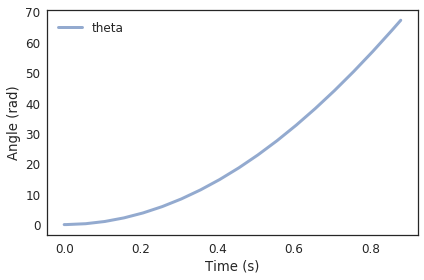

In [31]:
# Solution

plot_theta(results)

`y` should decrease and accelerate down.

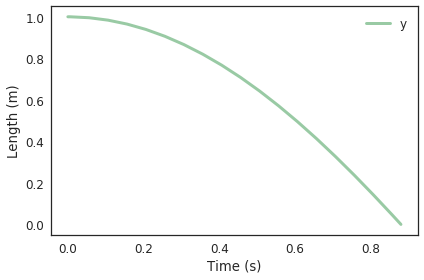

In [32]:
# Solution

plot_y(results)

Plot velocity as a function of time; is the yo-yo accelerating?

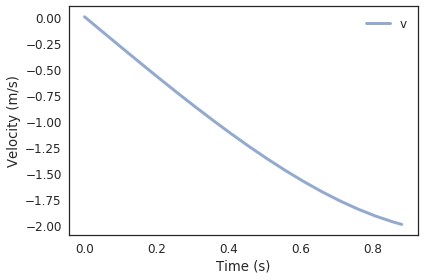

In [33]:
# Solution

v = results.v * m / s
plot(v)
decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Use `gradient` to estimate the derivative of `v`.  How goes the acceleration of the yo-yo compare to `g`?

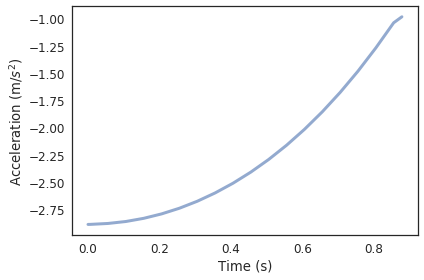

In [34]:
# Solution

a = gradient(v)
plot(a)
decorate(xlabel='Time (s)',
         ylabel='Acceleration (m/$s^2$)')